In [1]:
import pandas as pd
import numpy as np
import time
import datetime
# 读取数据
raw_data = pd.read_csv('./train.csv')
# **********数据探索***********
# 标签编码
raw_data['goods_id'] = pd.factorize(raw_data['goods_id'])[0]
print(raw_data['goods_id'].value_counts())

# 0代表未知， 1 代表男， 2 代表女
print(raw_data['customer_gender'].value_counts())
print(raw_data['customer_city'].value_counts())
print(raw_data['customer_province'].value_counts())
print(raw_data.info)
print(raw_data.isnull().sum())

# 当前数据集最晚时间 2013-08-31 23:59:59
# 当前数据集最早时间 2012-11-01 00:00:07
# 要预测的下个月是 9月份， 下下个月10月份
print(max(raw_data['order_pay_time']))
print(min(raw_data['order_pay_time']))
# 数据构造： 训练集8月之前， 验证集8月份
# 测试： 9月之前，预测9月
# 8月份之前的数据作为训练集
train_raw = raw_data[raw_data['order_pay_time']<= '2013-07-31 23:59:59']

0       472943
5       171277
243      91748
73       67783
121      60263
         ...  
947          1
949          1
950          1
1011         1
1036         1
Name: goods_id, Length: 1037, dtype: int64
0.0    603970
2.0     18468
1.0     13352
Name: customer_gender, dtype: int64
上海市      117625
北京市       71394
广州市       59772
杭州市       53752
武汉市       47894
          ...  
宜兰县           1
九龙            1
可克达拉市         1
台中市           1
新北市           1
Name: customer_city, Length: 375, dtype: int64
广东省         255700
江苏省         206593
浙江省         188219
河南省         131419
山东省         128916
上海          117625
湖北省         113378
湖南省         106706
安徽省         102575
江西省         102274
四川省          82279
福建省          81888
河北省          79617
北京           71394
辽宁省          59402
广西壮族自治区      54188
山西省          51759
陕西省          45786
天津           42147
黑龙江省         40328
云南省          40250
重庆           37459
贵州省          33775
内蒙古自治区       27119
吉林省          26839
新疆维吾尔自治区     230

In [2]:
# **********数据预处理**********
def preprocess(raw, train='train'):
    start = time.time()
    # 性别： 0未知 1男 2女
    data = pd.DataFrame(raw.groupby('customer_id')['customer_gender'].last().fillna(0))
    # 添加新的特征列（针对每个用户，最后一次行为）商品相关
    data[['goods_id_last','goods_status_last','goods_price_last','goods_has_discount_last','goods_list_time_last','goods_delist_time_last']] = \
        raw.groupby('customer_id')['goods_id','goods_status', 'goods_price', 'goods_has_discount', 'goods_list_time', 'goods_delist_time'].last()
    # 添加新的特征列（针对每个用户，最后一次行为）订单相关
    data[['order_total_num_last', 'order_amount_last', 'order_total_payment_last', 'order_total_discount_last', 'order_pay_time_last',\
          'order_status_last', 'order_count_last', 'is_customer_rate_last','order_detail_status_last','order_detail_goods_num_last',\
          'order_detail_amount_last', 'order_detail_payment_last', 'order_detail_discount_last']] = raw.groupby('customer_id')['order_total_num', \
          'order_amount', 'order_total_payment', 'order_total_discount', 'order_pay_time',\
          'order_status', 'order_count', 'is_customer_rate','order_detail_status','order_detail_goods_num',\
          'order_detail_amount', 'order_detail_payment', 'order_detail_discount'].last()
    # 添加商品原始价格goods_price统计字段： std， mean， min， max
    data[['goods_price_std','goods_price_mean','goods_price_min','goods_price_max']] = raw.groupby('customer_id').agg(\
        {'goods_price':['std','mean','min','max']})
    # 添加订单实付金额order_detail_payment统计字段： std， mean， min， max
    data[['order_detail_payment_std','order_detail_payment_mean','order_detail_payment_min','order_detail_payment_max']] = raw.groupby('customer_id').agg(\
        {'order_detail_payment':['std','mean','min','max']})
    
    # 用户购买的订单数量
    data['count'] = raw.groupby('customer_id')['order_id'].nunique() # 没有重复的数量
    # 用户购买的商品数量
    data['goods_count'] = raw.groupby('customer_id')['order_total_num'].sum()
    # 用户所在省份
    data['customer_province'] = raw.groupby('customer_id')['customer_province'].last() # 如果存在多个， 取最后一个 或取众数
    # 用户所在城市
    data['customer_city'] = raw.groupby('customer_id')['customer_city'].last()
    # 用户是否评价 统计结果（平均，总和）
    data[['is_customer_rate_ratio', 'is_customer_rate_sum']] = raw.groupby('customer_id').agg({'is_customer_rate':[np.mean,np.sum]})
    # 用户购买的goods数量
    data['order_detail_count'] = raw.groupby('customer_id')['order_detail_id'].count()
    # 商品折扣统计属性（sum, mean）
    data[['goods_has_discount_sum','goods_has_discount_mean']] = raw.groupby('customer_id').agg(\
        {'goods_has_discount':[np.mean, np.sum]})
    # 订单实付金额 统计属性（sum, mean）
    data[['order_total_payment_sum','order_total_payment_mean']] = raw.groupby('customer_id').agg(\
        {'order_total_payment':[np.mean, np.sum]})
    # 订单商品数量 统计属性（sum, mean）
    data[['order_total_num_sum','order_total_numt_mean']] = raw.groupby('customer_id').agg(\
        {'order_total_num':[np.mean, np.sum]})
        
    # 时间转换函数， 拆分成 month， day， weekday，hour， mimute， second
    def time2multi(x):
        t = datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
        return pd.Series([t.month, t.day, t.weekday(), t.hour, t.minute, t.second])
    #订单付款时间 原始的order_pay_time_last为2013-01-01 00:00:00，需要进行格式转换
    data[['order_pay_time_last_m', 'order_pay_time_last_d', 'order_pay_time_last_week', \
          'order_pay_time_last_h', 'order_pay_time_last_min', 'order_pay_time_last_s']] = data['order_pay_time_last'].apply(time2multi)
    # 商品最新上架时间diff（假设起始时间为2013-01-01 00:00:00）
    t_str = '2013-01-01 00:00:00'
    t = datetime.datetime.strptime(t_str, '%Y-%m-%d %H:%M:%S')
    data['goods_list_time_diff'] = data['goods_list_time_last'].map(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - t ).days/365)
    # 商品最新下架时间diff（假设起始时间为2013-01-01 00:00:00）
    data['goods_delist_time_diff'] = data['goods_delist_time_last'].map(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - t ).days/365)
    # 商品展示时间（下架时间-上架时间）
    data['good_diff'] = data['goods_delist_time_diff'] - data['goods_list_time_diff']
    # 付款时间diff
    data['order_pay_time_last_diff'] = data['order_pay_time_last'].map(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - t ).days/365) 

    end = time.time()
    print('preprocess_time:', end-start )
    
    return data
train_raw  = preprocess(train_raw)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if sys.path[0] == '':


preprocess_time: 388.4061088562012


In [4]:
import pickle 
with open('train_raw.pkl','wb') as file:
    pickle.dump(train_raw, file)


In [5]:
# 8月份数据作为标签
label_raw = set(raw_data[raw_data['order_pay_time'] > '2013-07-31 23:59:59']['customer_id'].dropna())
train_raw['labels'] = train_raw.index.map(lambda x: int(x in label_raw))
# 如果要划分验证集，6月份预测7月份，用model做7月验证8月，8月测试9月
#测试集就是全部的样本，即8.31之前的数据
test = preprocess(raw_data)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if sys.path[0] == '':


preprocess_time: 464.32824897766113


In [6]:
with open('test_raw.pkl','wb') as file:
    pickle.dump(test, file)

In [12]:
# 删除用于计算diff的临时变量
train_data = train_raw.drop(['goods_list_time_last','goods_delist_time_last','order_pay_time_last'], axis = 1)
# 去掉关系不大的字段， customer_province
train_data = train_data.drop(['customer_province','customer_city'], axis = 1)

# 分类变量
catel = ['order_pay_time_last_m', 'order_pay_time_last_week', 'order_pay_time_last_h','order_status_last', 'order_detail_status_last',\
         'goods_status_last', 'goods_id_last', 'goods_has_discount_last', 'customer_gender']

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1435404 entries, 1000000 to 2826574
Data columns (total 47 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   customer_gender              1435404 non-null  float64
 1   goods_id_last                1435404 non-null  int64  
 2   goods_status_last            1435404 non-null  float64
 3   goods_price_last             1435280 non-null  float64
 4   goods_has_discount_last      1435404 non-null  float64
 5   order_total_num_last         1435404 non-null  float64
 6   order_amount_last            1435404 non-null  float64
 7   order_total_payment_last     1435404 non-null  float64
 8   order_total_discount_last    1435404 non-null  float64
 9   order_status_last            1435404 non-null  int64  
 10  order_count_last             1435404 non-null  float64
 11  is_customer_rate_last        1435404 non-null  float64
 12  order_detail_status_last     1435404

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_data.drop('labels', axis=1), np.array(train_data['labels']),test_size=0.2)


In [47]:
from sklearn.model_selection import KFold
# 采用CV=5折交叉验证
kf = KFold(n_splits=5, shuffle=True)
y_pre = 0
import lightgbm as lgb
for train_index, test_index in kf.split(train_data):
    #设置每折的train和valid
    X_train, X_valid, y_train, y_valid = train_data.drop('labels', axis=1).iloc[train_index], train_data.drop('labels', axis=1).iloc[test_index], \
                np.array(train_data['labels'])[train_index], np.array(train_data['labels'])[test_index]
    param = {
            'num_leaves':96,
            'boosting_type':'gbdt',
            'objective':'binary',
            'max_depth': 6,
            'learning_rate':0.05,
            'metric':'binary_logloss'
            }
    # 使用lgb进行训练
    trn_data = lgb.Dataset(X_train, label = y_train)
    val_data = lgb.Dataset(X_valid, label = y_valid)
    lgbm = lgb.train(param, trn_data, valid_sets=[trn_data, val_data], num_boost_round=10000, early_stopping_rounds = 50, verbose_eval=50, categorical_feature=catel)
    # 得到test预测结果
    test = test[X_train.columns]
    y_pre = y_pre + lgbm.predict(test)

/home/stu_13768580091/.local/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['customer_gender', 'goods_has_discount_last', 'goods_id_last', 'goods_status_last', 'order_detail_status_last', 'order_pay_time_last_h', 'order_pay_time_last_m', 'order_pay_time_last_week', 'order_status_last']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Info] Number of positive: 18193, number of negative: 1130130
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6314
[LightGBM] [Info] Number of data points in the train set: 1148323, number of used features: 46


/home/stu_13768580091/.local/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/stu_13768580091/.local/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015843 -> initscore=-4.129051
[LightGBM] [Info] Start training from score -4.129051
Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.0672385	valid_1's binary_logloss: 0.0703159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[100]	training's binary_logloss: 0.0656667	valid_1's binary_logloss: 0.0701814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [48]:
# 5次结果求平均值
y_pre = y_pre / 5
#输出feature_importance
feature_importance = pd.DataFrame({'colum':X_train.columns, 'importance':lgbm.feature_importance()}).sort_values(by='importance')
print(feature_importance)

                          colum  importance
35        order_total_numt_mean           0
4       goods_has_discount_last           1
43       goods_delist_time_diff           4
5          order_total_num_last           8
11        is_customer_rate_last          12
44                    good_diff          13
28         is_customer_rate_sum          14
13  order_detail_goods_num_last          19
36        order_pay_time_last_m          20
10             order_count_last          20
2             goods_status_last          21
9             order_status_last          29
12     order_detail_status_last          29
34          order_total_num_sum          31
38     order_pay_time_last_week          33
30       goods_has_discount_sum          41
15    order_detail_payment_last          42
26                  goods_count          46
31      goods_has_discount_mean          51
29           order_detail_count          57
27       is_customer_rate_ratio          60
14     order_detail_amount_last 

In [49]:
print(len(y_pre))
print(min(y_pre))
print(max(y_pre))

1585986
0.0015145804101696174
0.9157585521331543


In [50]:
#在0，1附近，如果预测错误，损失很大
#削弱0,1附近的影响，因为结果有log，一旦分错，接近0,1部分影响非常大
# 采用保守策略
def f(x):
    if x < 0.1:
        return 0.1
    if x > 0.9:
        return 0.9
    return x

test['result'] = y_pre
test['result'] = test['result'].map(f)
answers = pd.DataFrame(test['result'])
answers.to_csv('submission.csv')

In [51]:
answers

,result
customer_id,
1000000,0.10000
1000014,0.10000
1000034,0.10000
1000046,0.10000
1000048,0.10000
...,...
2826570,0.10000
2826571,0.10000
2826572,0.10000


In [55]:
# 对answer_label进行字段统计
print(answers.mean())
print(answers.min())
print(answers.max())
print(answers.std())

#有时，需要对测试数据结果进行字段统计，若与训练数据相差大则欠拟合或过拟合 =》调整超参数（epoch， size， feature_num, lr,）


result    0.102609
dtype: float64
result    0.1
dtype: float64
result    0.9
dtype: float64
result    0.027949
dtype: float64


In [54]:
# 检查样本是否均匀
def check_imbalance(dataset):
    count = dataset['labels'].value_counts()
    # count = sorted(Counter(dataset).items())
    print(count)
    print(count[0]/count[1])
    return
check_imbalance(train_data)

0    1412601
1      22803
Name: labels, dtype: int64
61.94803315353243


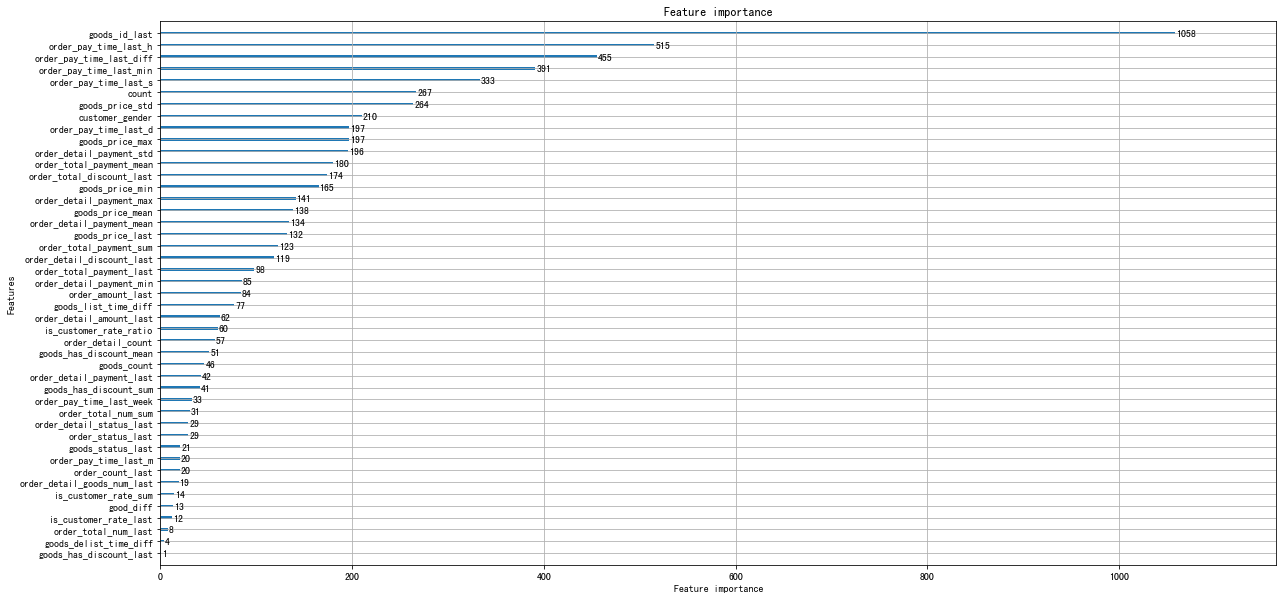

In [64]:
# 画出特征的重要程度
import matplotlib.pyplot as plt
from lightgbm import plot_importance
plot_importance(lgbm,figsize=(20,10))